### Import Libraries
Importing all the libraries we will need later on

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import precision_score, make_scorer,accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = None


### Import datasets
#### Import ready dataset from disk with all the information needed

In [13]:
## if you run it in colab, open run the following code to read the data from google drive
## First you need to upload them 
from google.colab import drive
drive.mount('/content/drive')

# Replace the path with the actual location of your file
file_path = '/content/drive/My Drive/full_dataset.csv'
df = pd.read_csv(file_path)

ModuleNotFoundError: No module named 'google.colab'

In [24]:
df = pd.read_csv('data/ml_ready/full_dataset.csv')
df['date'] = pd.to_datetime(df['date'])

In [25]:
## We create unnouncement column for each of the macro indicators
df['ppi_announcement'] = df['ppi_actual'].notna().astype(int)
df['unemployment_announcement'] = df['unemployment_actual'].notna().astype(int)
df['cpi_announcement'] = df['cpi_actual'].notna().astype(int)
df['interest_rates_announcement'] = df['interest_rates_actual'].notna().astype(int)

### Feature Engineering

In [28]:
# candle stick features for zf 
df['high_low'] = df['high'] - df['low']
df['body'] = df['close'] - df['open']
df['zf_change'] = df['close'].diff()
df['zf_change_pct'] = df['zf_change'] * 100

# Calendar features
df["day_of_week"] = df['date'].dt.dayofweek
df["day_of_month"] = df['date'].dt.day
# df["week_of_year"] = df['date'].dt.isocalendaar().week
# df["week_of_year"] = df['week_of_year'].astype('int64')
df["month"] = df['date'].dt.month
df["quarter"] = df['date'].dt.quarter
df["is_month_end"] = df['date'].dt.is_month_end.astype(int)
df["is_month_start"] = df['date'].dt.is_month_start.astype(int)

# target 
df['tomorrow'] = df['close'].shift(-1)
df['target'] = (df['tomorrow'] > df['close']).astype(int)

df['target_momentum'] = df['target'].apply(lambda x: 1 if x == 1 else -1).cumsum()


In [29]:
df.head()

,date,open,high,low,close,volume,ppi_actual,ppi_forecast,ppi_previous,ppi_dev_forecast,ppi_dev_previous,ppi_pct_deviation_forecast,unemployment_actual,unemployment_forecast,unemployment_previous,unemployment_dev_forecast,unemployment_dev_previous,unemployment_pct_deviation_forecast,cpi_actual,cpi_forecast,cpi_previous,cpi_dev_forecast,cpi_dev_previous,cpi_pct_deviation_forecast,interest_rates_actual,interest_rates_forecast,interest_rates_previous,interest_rates_dev_forecast,interest_rates_dev_previous,interest_rates_pct_deviation_forecast,ppi_announcement,unemployment_announcement,cpi_announcement,interest_rates_announcement,high_low,body,zf_change,zf_change_pct,day_of_week,day_of_month,month,quarter,is_month_end,is_month_start,tomorrow,target,target_momentum
0,2010-01-04,114.250000,114.632812,114.062500,114.546875,295473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0.570312,0.296875,NaN,NaN,0,4,1,1,0,0,114.945312,1,1
1,2010-01-05,114.609375,115.007812,114.593750,114.945312,393545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0.414062,0.335938,0.398438,39.84375,1,5,1,1,0,0,114.906250,0,0
2,2010-01-06,114.882812,114.929688,114.640625,114.906250,473208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0.289062,0.023438,-0.039062,-3.90625,2,6,1,1,0,0,114.796875,0,-1
3,2010-01-07,114.820312,114.929688,114.578125,114.796875,357551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0.351562,-0.023438,-0.109375,-10.93750,3,7,1,1,0,0,115.007812,1,0
4,2010-01-08,114.734375,115.195312,114.554688,115.007812,357551,NaN,NaN,NaN,NaN,NaN,NaN,0.1,0.101,0.1,-0.001,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0.640625,0.273438,0.210938,21.09375,4,8,1,1,0,0,115.031250,1,1


As you can see, there as lots of missing data, thats because the macroindicator data is sparse with values only around announcements. Given that, we will fill the missing values with forward fill

In [30]:
df[df.columns] = df.apply(lambda col: col.ffill() if col.isna().sum() > 100 else col)
df = df.dropna()
df.head(10)

,date,open,high,low,close,volume,ppi_actual,ppi_forecast,ppi_previous,ppi_dev_forecast,ppi_dev_previous,ppi_pct_deviation_forecast,unemployment_actual,unemployment_forecast,unemployment_previous,unemployment_dev_forecast,unemployment_dev_previous,unemployment_pct_deviation_forecast,cpi_actual,cpi_forecast,cpi_previous,cpi_dev_forecast,cpi_dev_previous,cpi_pct_deviation_forecast,interest_rates_actual,interest_rates_forecast,interest_rates_previous,interest_rates_dev_forecast,interest_rates_dev_previous,interest_rates_pct_deviation_forecast,ppi_announcement,unemployment_announcement,cpi_announcement,interest_rates_announcement,high_low,body,zf_change,zf_change_pct,day_of_week,day_of_month,month,quarter,is_month_end,is_month_start,tomorrow,target,target_momentum
31,2010-02-18,116.351562,116.500000,115.898438,116.109375,601111,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,0.001,0.001,0.000,0.000,0.001,100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,1,0,0,0,0.601562,-0.242188,-0.242188,-24.21875,3,18,2,1,0,0,115.976562,0,2
32,2010-02-19,115.906250,116.132812,115.789062,115.976562,622341,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,-0.001,0.002,0.001,-0.003,-0.002,-100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,0,0,1,0,0.343750,0.070312,-0.132812,-13.28125,4,19,2,1,0,0,116.046875,1,3
33,2010-02-22,115.984375,116.117188,115.937500,116.046875,421823,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,-0.001,0.002,0.001,-0.003,-0.002,-100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,0,0,0,0,0.179688,0.062500,0.070312,7.03125,0,22,2,1,0,0,116.507812,1,4
34,2010-02-23,116.039062,116.585938,116.015625,116.507812,861801,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,-0.001,0.002,0.001,-0.003,-0.002,-100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,0,0,0,0,0.570312,0.468750,0.460938,46.09375,1,23,2,1,0,0,116.476562,0,3
35,2010-02-24,116.523438,116.679688,116.390625,116.476562,987756,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,-0.001,0.002,0.001,-0.003,-0.002,-100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,0,0,0,0,0.289062,-0.046875,-0.031250,-3.12500,2,24,2,1,0,0,116.820312,1,4
36,2010-02-25,116.492188,116.898438,116.460938,116.820312,717831,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,-0.001,0.002,0.001,-0.003,-0.002,-100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,0,0,0,0,0.437500,0.328125,0.343750,34.37500,3,25,2,1,0,0,117.046875,1,5
37,2010-02-26,116.828125,117.070312,116.750000,117.046875,162782,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,-0.001,0.002,0.001,-0.003,-0.002,-100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,0,0,0,0,0.320312,0.218750,0.226562,22.65625,4,26,2,1,0,0,117.031250,0,4
38,2010-03-01,116.851562,117.093750,116.820312,117.031250,66564,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,-0.001,0.002,0.001,-0.003,-0.002,-100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,0,0,0,0,0.273438,0.179688,-0.015625,-1.56250,0,1,3,1,0,1,117.093750,1,5
39,2010-03-02,116.984375,117.140625,116.867188,117.093750,39987,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,-0.001,0.002,0.001,-0.003,-0.002,-100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,0,0,0,0,0.273438,0.109375,0.062500,6.25000,1,2,3,1,0,0,117.109375,1,6
40,2010-03-03,117.109375,117.171875,116.945312,117.109375,27178,0.014,0.008,0.004,0.006,0.01,125.0,0.097,0.1,0.1,-0.003,-0.003,-3.0,-0.001,0.002,0.001,-0.003,-0.002,-100.0,0.0025,0.0025,0.0025,0.0,0.0,0.0,0,0,0,0,0.226562,0.000000,0.015625,1.56250,2,3,3,1,0,0,117.031250,0,5


Now we have a much better dataset that we can work with. 

In [37]:
features = ['open', 'high', 'low', 'close', 'volume', 'ppi_actual',
       'ppi_forecast', 'ppi_previous', 'ppi_dev_forecast', 'ppi_dev_previous',
       'unemployment_actual','unemployment_forecast', 'unemployment_previous',
       'unemployment_dev_forecast', 'unemployment_dev_previous', 'target_momentum',
        'cpi_actual', 'cpi_forecast','cpi_previous', 'cpi_dev_forecast', 'cpi_dev_previous',
        'interest_rates_actual', 'interest_rates_forecast', 'interest_rates_previous',
       'interest_rates_dev_forecast', 'interest_rates_dev_previous',
        'ppi_announcement','unemployment_announcement', 'cpi_announcement',
       'interest_rates_announcement', 'high_low', 'body', 'zf_change',
       'day_of_week', 'day_of_month', 
#             'week_of_year', 
            'month',
       'quarter', 'is_month_end', 'is_month_start']

target = 'target'

In [38]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42, stratify=df[target])

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy: 0.5757

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57       369
           1       0.58      0.58      0.58       371

    accuracy                           0.58       740
   macro avg       0.58      0.58      0.58       740
weighted avg       0.58      0.58      0.58       740



### Feature Importances
Lets find out witch columns have the best predictability

                    Feature  Importance
37             is_month_end    0.040091
38           is_month_start    0.037995
23  interest_rates_previous    0.031075
26         ppi_announcement    0.030786
15          target_momentum    0.029336
3                     close    0.029328
12    unemployment_previous    0.029106
21    interest_rates_actual    0.028932
22  interest_rates_forecast    0.028815
11    unemployment_forecast    0.028238


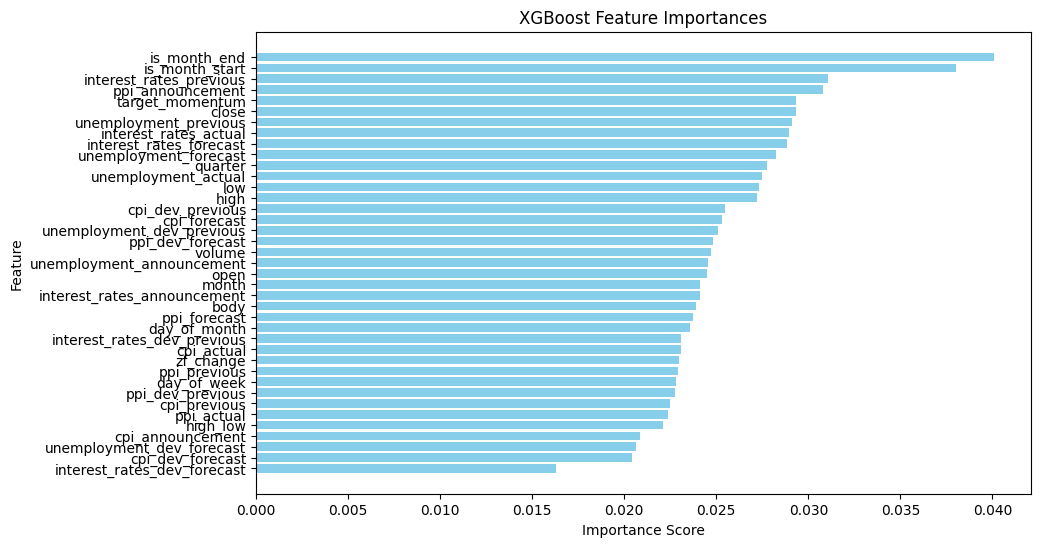

In [39]:
# Get feature importance scores
feature_importances = xgb_model.feature_importances_

# Convert to DataFrame for better visualization
feature_importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

# Print the top features
print(feature_importance_df.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importances")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [40]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=150, step=20):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

# Example usage
predictors = features  # Replace with actual features

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# # Define LightGBM model
# lgb_model = lgb.LGBMClassifier(
#     objective='binary',          # Binary classification
#     metric='binary_logloss',     # Equivalent to XGBoost's logloss
#     max_depth=6,                # Maximum tree depth
#     learning_rate=0.1,          # Learning rate
#     n_estimators=100,           # Number of boosting iterations
#     subsample=0.8,              # Subsample ratio of training instances
#     colsample_bytree=0.8,       # Subsample ratio of columns
#     random_state=42,            # For reproducibility
#     n_jobs=-1                   # Use all available CPU cores
# )
# Run backtest with cross-validation
xgb_results = backtest(df, xgb_model, predictors)
print(f"============ XGBoost Results ============")
print(xgb_results)

# lgb_results = backtest(df, lgb_model,predictors)
# print(f"============ LightGBM Results ============")
# print(lgb_results)


============ XGBoost Results ============
      target  Predictions
181        0            1
182        0            0
183        1            1
184        1            1
185        0            0
...      ...          ...
3724       0            1
3725       1            1
3726       0            0
3727       0            0
3728       1            1

[3548 rows x 2 columns]


In [41]:
print("XGBoost Precision Score:")
print(precision_score(xgb_results["target"], xgb_results["Predictions"]))

# print("LightGBM Precision Score:")
# print(precision_score(lgb_results["target"], lgb_results["Predictions"]))


XGBoost Precision Score:
0.555668016194332


### Conclusions
1. Overall **precision: 55%** which is close to random.
2. **Best 10 features** with most predictability are: 
    - is_month_end    
    - interest_rates_previous    
    - month    
    - low    
    - volume    
    - unemployment_previous    
    - cpi_dev_forecast    
    - ppi_announcement        
    - unemployment_forecast
   

### Nest steps 
1. Create more features
2. Formulate again the problem
3. Define new targets
